In [ ]:
!pip install transformers seqeval[gpu]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification
from torch import cuda


device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

MAX_LEN = 256
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 2
LEARNING_RATE = 3e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

label2id = {'c':0,'i':1,'x':2}
id2label = {0:'c',1:'i',2:'x'}

cuda


In [ ]:
def process_data(file):
      f = open(file)
      data = []
      sentences = []
      labels = []
      sentence = []
      label= []
      for line in f:
                  l=line.split('\t')
                  if len(l)==0 or l[0]=="\n" or l[0]=="  \n":
                      if len(sentence) > 0:
                          sentences.append(sentence)
                          labels.append(label)
                          sentence = []
                          label = []
                      continue

                  sentence.append(l[0])
                  label.append(l[1].strip())

      if len(sentence) >0:
                  sentences.append(sentence)
                  labels.append(label)
                  sentence = []
                  label = []
      return pd.DataFrame({'sentence': sentences, 'labels':labels})

In [ ]:
def tokenize_data(sentence, text_labels, tokenizer):

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):
        token_list = tokenizer.tokenize(word)
        for m,token in enumerate(token_list):
            tokenized_sentence.append(token)
            if m==0:
                labels.append(label)
            else:
                labels.append('x')  

    return tokenized_sentence, labels

In [ ]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
   
        sentence = self.data.sentence[index]  
        word_labels = self.data.labels[index]  
        tokenized_sentence, labels = tokenize_data(" ".join(sentence), ",".join(word_labels), self.tokenizer)

        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] 
        labels.insert(0, "c") 
        labels.insert(-1, "c") 

        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["c" for _ in range(maxlen - len(labels))]

        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        
        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [ ]:
training_set = dataset(process_data("train.tsv"), tokenizer, MAX_LEN)
validation_set = dataset(process_data("dev.tsv"), tokenizer, MAX_LEN)
testing_set = dataset(process_data("dev.tsv"), tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

validation_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **validation_params)
testing_loader = DataLoader(testing_set, **test_params)

model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', 
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        flattened_targets = targets.view(-1) 
        active_logits = tr_logits.view(-1, model.num_labels) 
        flattened_predictions = torch.argmax(active_logits, axis=1) 
        active_accuracy = mask.view(-1) == 1 
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_preds.extend(predictions)
        tr_labels.extend(targets)
        
        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")
    return epoch_loss


In [ ]:
epoch_loss_list = []
epochs_list = []
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    epoch_loss = train(epoch)
    epoch_loss_list.append(epoch_loss)
    epochs_list.append(epoch)


Training epoch: 1
Training loss per 100 training steps: 1.017642855644226
Training loss per 100 training steps: 0.06962445161609661
Training loss per 100 training steps: 0.04517301205263024
Training loss per 100 training steps: 0.03721100455258301
Training loss per 100 training steps: 0.0326220219637827
Training loss per 100 training steps: 0.030065710708859588
Training loss per 100 training steps: 0.0283439218499752
Training loss per 100 training steps: 0.02668922626979373
Training loss per 100 training steps: 0.025415651423777552
Training loss per 100 training steps: 0.02442608064828186
Training loss per 100 training steps: 0.023533672326245345
Training loss per 100 training steps: 0.02282014242259212
Training loss per 100 training steps: 0.022288029301185765
Training loss per 100 training steps: 0.021765856480699813
Training loss per 100 training steps: 0.02134328932889593
Training loss per 100 training steps: 0.020876508500541173
Training loss epoch: 0.02056339096994063
Training ac

In [ ]:
def valid(model, data_set):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx in range(len(data_set)):
            batch = data_set.__getitem__(idx)
            ids = batch['ids'].to(device, dtype = torch.long).expand(1,256)
            mask = batch['mask'].to(device, dtype = torch.long).expand(1,256)
            targets = batch['targets'].to(device, dtype = torch.long).expand(1,256)
            
            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)
  
            flattened_targets = targets.view(-1) 
            active_logits = eval_logits.view(-1, model.num_labels) 
            flattened_predictions = torch.argmax(active_logits, axis=1) 
            active_accuracy = mask.view(-1) == 1 
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            tokens_temp = tokenizer.convert_ids_to_tokens(ids[0])
            sep_index = tokens_temp.index('[SEP]')
            new_words = tokens_temp[1:sep_index]
            new_labels = predictions[1:sep_index]
            eval_labels.extend(targets)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]
        
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps

    return labels, predictions, eval_loss, eval_accuracy


In [ ]:
def get_filtered_preds(labels, predictions):
    new_labels = []
    new_predictions = []
    for i in range(len(labels)):
        if(labels[i]!='x' and predictions[i]!='x'):
          new_labels.append(labels[i])
          new_predictions.append(predictions[i])
    return new_labels, new_predictions

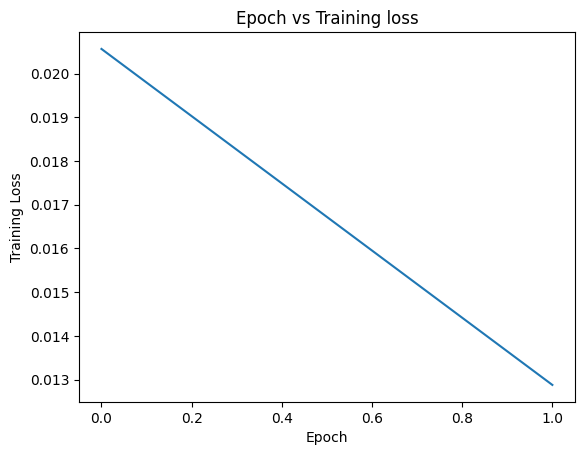

In [ ]:
import matplotlib.pyplot as plt
  
plt.plot(epochs_list, epoch_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Epoch vs Training loss')
plt.show()

In [ ]:
labels_val, predictions_val, loss_val, accuracy_val  = valid(model, validation_set)
labels_val, predictions_val = get_filtered_preds(labels_val, predictions_val)


In [ ]:
target_names = ['c','i']

print(set(labels_val), set(predictions_val))
from sklearn.metrics import classification_report


print("validation data report:")
print(classification_report(labels_val, predictions_val, target_names=target_names))

print("Total validation loss: ",loss_val)
print("Total validation accuracy: ",accuracy_val)

{'i', 'c'} {'i', 'c'}
validation data report:
              precision    recall  f1-score   support

           c       0.93      0.99      0.96      9438
           i       0.81      0.41      0.54      1210

    accuracy                           0.92     10648
   macro avg       0.87      0.70      0.75     10648
weighted avg       0.92      0.92      0.91     10648

Total validation loss:  0.012525184224578354
Total validation accuracy:  0.9384214366390808
